In [118]:
from IPython import display
from utils import Logger
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transformsbn, datasets

In [119]:
def Fashion_mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize([0.5], [0.5])]
         #transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        )
    out_dir = './dataset'
    return datasets.FashionMNIST(root=out_dir, train=True, transform=compose, download=True)

# Load data
data = Fashion_mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)  #600*100
num_batches

600

In [120]:
# batch=100.  total 600 batch 

In [121]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            #nn.LeakyReLU(0.2),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            #nn.LeakyReLU(0.2),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x


discriminator = DiscriminatorNet()



In [122]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            #nn.LeakyReLU(0.2)
            nn.ReLU()
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            #nn.LeakyReLU(0.2)
            nn.ReLU()
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            #nn.LeakyReLU(0.2)
            nn.ReLU()
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
generator = GeneratorNet()

In [123]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n

In [124]:
#Variable(torch.randn(2, 100)).shape

In [125]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [126]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

In [127]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

In [128]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

loss = nn.BCELoss()

In [129]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake



In [130]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    error = loss(prediction, ones_target(N))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [131]:
num_test_samples = 16
test_noise = noise(num_test_samples)

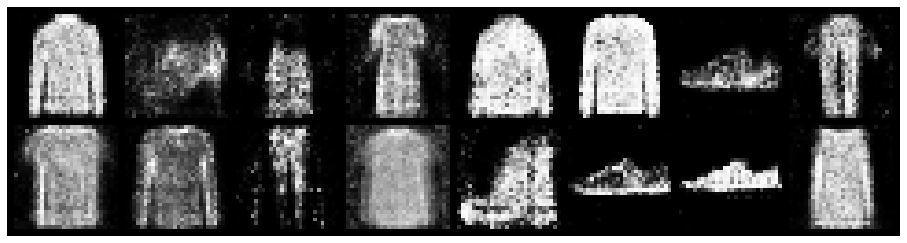

Epoch: [34/35], Batch Num: [500/600]
Discriminator Loss: 1.2788, Generator Loss: 1.0100
D(x): 0.5675, D(G(z)): 0.4271


In [132]:
logger = Logger(model_name='VGAN', data_name='MNIST')

D_loss=[]
G_loss=[]
N=60000

for epoch in range(num_epochs):
    LossD=0
    LossG=0
    for n_batch, (real_batch,_) in enumerate(data_loader):

        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)
        LossD+=d_error.item()

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)       
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        LossG+=g_error.item()
        
    
        

        # Display Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)
    D_loss.append(LossD/N)
    G_loss.append(LossG/N)
    print('D:',LossD/N,'G:',LossG/N)
print(D_loss,G_loss)  

In [83]:
# train the GAN model
#for n_batch, (real_batch,_) in enumerate(data_loader):
    #batch numbers,  batch data 
    #real_data = Variable(images_to_vectors(real_batch))
    

In [102]:
#logger = Logger(model_name='VGAN', data_name='MNIST')
D_loss=[]
G_loss=[]
N=60000
#num_epochs
for epoch in range(50):
    LossD=0
    LossG=0
    for n_batch, (real_batch,_) in enumerate(data_loader):

        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)
        LossD+=d_error.item()
        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G return loss
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        #logger.log(d_error, g_error, epoch, n_batch, num_batches)
        LossG+=g_error.item()
    
    D_loss.append(LossD/N)
    G_loss.append(LossG/N)
    print('D:',LossD/N,'G:',LossG/N)
    #print('Avg D_loss',d_error.data.cpu().numpy(),'Avg G_loss', d_error.data.cpu().numpy())
print(D_loss,G_loss)  

D: 0.0017161526673512223 G: 0.05734659224698941
D: 0.0016557872719257527 G: 0.06350394744873047
D: 0.002033423044051354 G: 0.04876760913133621
D: 0.0019526974676797788 G: 0.04599425167242686
D: 0.0027749787718057634 G: 0.037481775625546776
D: 0.002929991764823596 G: 0.03562990867694219
D: 0.0032544410437345505 G: 0.03364826995531718
D: 0.003678392308826248 G: 0.03167884795268377
D: 0.0043857436388731 G: 0.029403559482097625
D: 0.004791414189090331 G: 0.0279348049501578
D: 0.0051558507025241855 G: 0.026226664358377456
D: 0.0060370911881327625 G: 0.023209656327962874
D: 0.006669404415786266 G: 0.02126194803118706
D: 0.007272379728655021 G: 0.01945814114809036
D: 0.0077420259440938635 G: 0.018266264522075654
D: 0.008145463906725247 G: 0.017233244317770003
D: 0.008504196747144064 G: 0.016787679487466813
D: 0.009206775816281636 G: 0.015209763332207998
D: 0.00940272304614385 G: 0.014805974757671356
D: 0.009504660018285116 G: 0.014553394132852554
D: 0.009798491588234901 G: 0.01389399286607901

In [136]:
#torch.save(net, PATH)
#torch.save(net.state_dict(),PATH)
#generator.state_dict()
PATH="/Users/dl/generator"
torch.save(generator.state_dict(),PATH)
print("Succ")

Succ


In [103]:
print(D_loss,G_loss)

[0.0017161526673512223, 0.0016557872719257527, 0.002033423044051354, 0.0019526974676797788, 0.0027749787718057634, 0.002929991764823596, 0.0032544410437345505, 0.003678392308826248, 0.0043857436388731, 0.004791414189090331, 0.0051558507025241855, 0.0060370911881327625, 0.006669404415786266, 0.007272379728655021, 0.0077420259440938635, 0.008145463906725247, 0.008504196747144064, 0.009206775816281636, 0.00940272304614385, 0.009504660018285116, 0.009798491588234901, 0.00989856759905815, 0.009848164131244024, 0.010096708736817043, 0.010438492751121521, 0.0105930040816466, 0.010605783371130625, 0.010798641061782837, 0.010909470971425375, 0.011013948408762613, 0.011128614072004954, 0.011142370829979579, 0.011225054411093394, 0.011315617748101553, 0.01141675856411457, 0.011533525231480598, 0.011647299576799075, 0.011608545052011808, 0.011649772105614345, 0.01185405596892039, 0.011946728533506394, 0.011898115156094234, 0.011796080721418063, 0.011898595273494721, 0.012055263066291809, 0.0122137

Text(0, 0.5, 'Training Loss')

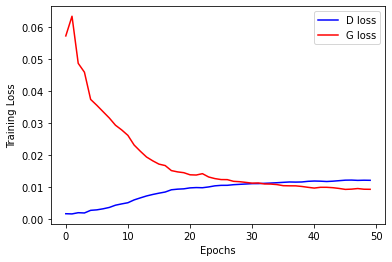

In [110]:
import matplotlib.pyplot as plt

plt.plot(D_loss,'b')
plt.plot(G_loss,'r')
plt.legend(['D loss','G loss'])
plt.xlabel('Epochs')
plt.ylabel('Training Loss')

In [ ]:
logger = Logger(model_name='VGAN', data_name='MNIST')
num_epochs=50
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):

        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)

        # Display Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)

In [ ]:
        
        # Display Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)